In [2]:
library(ANCOMBC)
library(qiime2R)
library(tidyr)
library(tibble)
library(ggplot2)
library(microbiome)
library(phyloseq)
library("tidyverse")
library("dplyr")
library(microViz)
library("ggpubr")

In [3]:
# Read in the 16S qza files and clean them up for phyloseq
ASVs <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/table-BacArc_resistada.qza")
ASVs <- ASVs$data # Extract the count data from list
taxa_16S <- read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/taxonomy_resistada.qza")
taxa_16S <- taxa_16S$data %>% as_tibble() %>% separate(Taxon, sep=";",
c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")) %>% 
# Convert taxonomy info to data frame with correct taxonomy labels
#taxa <- taxa_16S[-1,]
select(-Confidence) %>% arrange(Feature.ID) %>% mutate(ASV = 1:n()) %>% 
mutate(newcol = "ASV") %>%
unite("ASVs", newcol:ASV) %>%
filter(Phylum !=" p__Chlorophyta") %>%
filter(Phylum !="NA")
#asv_tab$asv_id <- rownames(asv_tab) # add a new column for ids
tree_file <-read_qza("/Users/stephanie.rosales/Documents/omics_projects/Resitada/qiime_output/rooted-BacArc_resistada.qza")$data

Warning message:
“Expected 7 pieces. Missing pieces filled with `NA` in 5374 rows [3, 6, 9, 11, 12, 14, 15, 16, 17, 18, 22, 23, 27, 31, 36, 38, 42, 45, 49, 51, ...].”


In [4]:
meta = read.csv("/Users/stephanie.rosales/Documents/omics_projects/Resitada/metadata_RESISTADA.csv", 
                header = T, row.names = 1,
na.strings = c("", "NA")) %>% 
mutate(
  Genotype = Genotype %>%
    str_replace_all("Kelsey-1", "Kelsey1") %>%
    str_replace_all("Cooper-9", "Cooper9")
)

meta$Genotype<-factor(meta$Genotype, 
                              levels=c("FM19", "FM6", "FM9", "U44",
                                       "FM14", "Elkhorn","K2",
                                      "Acerv2", "Kelsey1", "Cooper9"))

 meta$Combo<-factor(meta$Combo,
                       levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen"))


In [5]:
ps= phyloseq(otu_table(ASVs, taxa_are_rows= T),
tax_table(as.data.frame(taxa_16S) %>% column_to_rownames("Feature.ID") %>%
as.matrix()), sample_data(meta), tree_file)
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 280 samples ]
sample_data() Sample Data:       [ 280 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [6]:
dups = c("N169_256_R2", "N157_265_R2", "N165_296_R2", "N161_A067_R2", "N185_A088_R2",
                                 "N164_A089_R2","N119_A107","N267_A110","N7_A114", "N156_A115","N158_A116",
                                 "N101_A118","N160_A119","N277_A125")

ps = subset_samples(ps, !ID %in% dups & Genotype!=c("U41"))
                                                    #,"U44")) 
ps


ps=subset_taxa(ps, Phylum!="NA")
ps

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [7]:
ps_Clipped =subset_samples(ps, Type=="Clipped")
ps_Clipped

ps_paired = subset_samples(ps_Clipped, Pairs=="paired")
ps_paired

select =c("Ambient_Placebo", "Ambient_Pathogen")
#only nutrient and placebo
ps_disease =subset_samples(ps_paired, Combo %in% select)
ps_disease

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 192 samples ]
sample_data() Sample Data:       [ 192 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 135 samples ]
sample_data() Sample Data:       [ 135 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 9492 taxa and 62 samples ]
sample_data() Sample Data:       [ 62 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 9492 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 9492 tips and 8365 internal nodes ]

In [8]:
ps_disease_fill = filter_taxa(ps_disease, function(x) sum(x > 5) > (0.05*length(x)), TRUE) %>% tax_fix()
ps_disease_fill
                           
                                                                                    

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 255 taxa and 62 samples ]
sample_data() Sample Data:       [ 62 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 255 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 255 tips and 218 internal nodes ]

In [9]:
sample_data(ps_disease_fill) %>%
  group_by(Combo, Health) %>%
  summarize(Paired = n())

`summarise()` has grouped output by 'Combo'. You can override using the `.groups` argument.


Combo,Health,Paired
<fct>,<chr>,<int>
Ambient_Placebo,AH,36
Ambient_Pathogen,AH,3
Ambient_Pathogen,DL,23


In [10]:
set.seed(123)
output = ancombc2(data = ps_disease_fill , tax_level = "ASVs",
                  fix_formula = "Combo", 
                  #rand_formula = "(1| Genotype)",
                  p_adj_method = "holm",  pairwise = TRUE,
                  group = "Combo",struc_zero = TRUE, alpha = 0.001,
                  dunnet = TRUE,
                  n_cl=4, prv_cut = 0.01, lib_cut = 1000
                 )
        

Checking the input data type ...

The input data is of type: phyloseq

PASS

Checking the sample metadata ...

The specified variables in the formula: Combo

The available variables in the sample metadata: sample_names, featurecounts, Initial_sample_ID, Tag, start_date, event_date, Date_Collected, Date, TimePoint, Replicate, Genotype, Nursery, Nutrients, Diseased, Combo, Tank_N, Tank_D1, Tank_D2, Type, Health, Outcome, Notes, Severity, Survivorship, Pairs, Combo_health, Archive_box, Genotype.1, NH4_Susceptibility, Disease_Susceptibility, NH4_Disease_Susceptibility, Expected, Surv_disease, Surv_nutrients, surv, std.err, barcode_label, barcode_seq, ID, Sequencing_Round, Plate_Name, Plate_Barcode, Well_Position, Sequence_Name, Illumina5_Adapter, Forward_Primer_Pad, Golay_Barcode, X515FB_Forward_Primer, Primer_For_PCR, X, estimate, error, lower, upper, name, model, Simpson, Shannon

PASS

Checking other arguments ...

The number of groups of interest is: 2

Warning message:
“The group vari

In [11]:
res=output$res
head(res)
dim(res)

taxa_df = tax_table(ps_disease_fill) %>% as.data.frame() %>% rownames_to_column("taxon")
head(taxa_df)

df_fig = res %>% left_join(taxa_df, by = "taxon")
dim(df_fig)
head(df_fig)

,taxon,lfc_(Intercept),lfc_ComboAmbient_Pathogen,se_(Intercept),se_ComboAmbient_Pathogen,W_(Intercept),W_ComboAmbient_Pathogen,p_(Intercept),p_ComboAmbient_Pathogen,q_(Intercept),q_ComboAmbient_Pathogen,diff_(Intercept),diff_ComboAmbient_Pathogen,passed_ss_(Intercept),passed_ss_ComboAmbient_Pathogen
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<lgl>,<lgl>,<lgl>
1,f3dd427acd4dd5422d28130de4a38d07,0.21770889,-0.46534827,1.089611e-02,0.1746271,19.98043,-2.6648112,2.495528e-03,0.11668283,1.946512e-01,1,FALSE,FALSE,TRUE,TRUE
2,b38e455ff5afd35267d8f10060d463c6,0.19151946,-0.15078846,4.809407e-03,0.1692086,39.82185,-0.8911395,6.300089e-04,0.46688313,5.859082e-02,1,FALSE,FALSE,FALSE,TRUE
3,823c79a88cd4499479ebccd160c1d38b,-0.12516017,0.60500091,1.238478e-02,0.1695300,-10.10596,3.5686950,2.063656e-03,0.03758691,1.650925e-01,1,FALSE,FALSE,TRUE,TRUE
4,03ebce4eb76077e5720b4bff58448896,0.49869657,-0.81354356,NaN,0.1716691,NaN,-4.7390203,1.000000e+00,0.04175775,1.000000e+00,1,FALSE,FALSE,TRUE,TRUE
5,bec05b61187326748a5ba33a0267c26f,-0.06740728,0.04898734,2.275012e-06,0.1746367,-29629.40955,0.2805100,8.478163e-14,0.79731824,1.415853e-11,1,TRUE,FALSE,FALSE,TRUE
6,7dfdf546ed4b1ca29ad5fbc0fc732338,0.20274443,-0.10809819,2.275012e-06,0.1679255,89117.94197,-0.6437270,3.376588e-24,0.54811205,6.179157e-22,1,TRUE,FALSE,FALSE,TRUE


[1] 189  15

,taxon,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,796d808b1af4b8011de60e4dd4d2e3a6,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_4872
2,814c4938df1d40f53e14f3f2803a4e07,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_5153
3,f3dd427acd4dd5422d28130de4a38d07,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_9663
4,b38e455ff5afd35267d8f10060d463c6,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_7098
5,823c79a88cd4499479ebccd160c1d38b,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5181
6,03ebce4eb76077e5720b4bff58448896,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_146


[1] 189  23

,taxon,lfc_(Intercept),lfc_ComboAmbient_Pathogen,se_(Intercept),se_ComboAmbient_Pathogen,W_(Intercept),W_ComboAmbient_Pathogen,p_(Intercept),p_ComboAmbient_Pathogen,q_(Intercept),⋯,passed_ss_(Intercept),passed_ss_ComboAmbient_Pathogen,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,f3dd427acd4dd5422d28130de4a38d07,0.21770889,-0.46534827,1.089611e-02,0.1746271,19.98043,-2.6648112,2.495528e-03,0.11668283,1.946512e-01,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Caulobacterales,f__Hyphomonadaceae,g__uncultured,g__uncultured Genus,ASV_9663
2,b38e455ff5afd35267d8f10060d463c6,0.19151946,-0.15078846,4.809407e-03,0.1692086,39.82185,-0.8911395,6.300089e-04,0.46688313,5.859082e-02,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_7098
3,823c79a88cd4499479ebccd160c1d38b,-0.12516017,0.60500091,1.238478e-02,0.1695300,-10.10596,3.5686950,2.063656e-03,0.03758691,1.650925e-01,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5181
4,03ebce4eb76077e5720b4bff58448896,0.49869657,-0.81354356,NaN,0.1716691,NaN,-4.7390203,1.000000e+00,0.04175775,1.000000e+00,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_146
5,bec05b61187326748a5ba33a0267c26f,-0.06740728,0.04898734,2.275012e-06,0.1746367,-29629.40955,0.2805100,8.478163e-14,0.79731824,1.415853e-11,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_7554
6,7dfdf546ed4b1ca29ad5fbc0fc732338,0.20274443,-0.10809819,2.275012e-06,0.1679255,89117.94197,-0.6437270,3.376588e-24,0.54811205,6.179157e-22,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_5032


In [102]:
df_fig = res %>% left_join(taxa_df, by = "taxon") %>%
filter(lfc_ComboAmbient_Pathogen < -1 | lfc_ComboAmbient_Pathogen > 1)  %>%
filter(passed_ss_ComboAmbient_Pathogen == "TRUE") 
dim(df_fig)
head(df_fig)

[1] 29 23

,taxon,lfc_(Intercept),lfc_ComboAmbient_Pathogen,se_(Intercept),se_ComboAmbient_Pathogen,W_(Intercept),W_ComboAmbient_Pathogen,p_(Intercept),p_ComboAmbient_Pathogen,q_(Intercept),⋯,passed_ss_(Intercept),passed_ss_ComboAmbient_Pathogen,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,544e3f697c0460869c81cc5c7e774c6a,0.981519153,-1.112034,2.275012e-06,0.1689536,4.314346e+05,-6.581889,2.746160e-17,7.136037e-03,4.723394e-15,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodobacterales,f__Rhodobacteraceae,f__Rhodobacteraceae Family,f__Rhodobacteraceae Family,ASV_3397
2,46f3b8bd39ad98e3a511ccd4d594ffc9,-1.516598646,1.921686,NaN,0.1709505,NaN,11.241183,1.000000e+00,1.509379e-03,1.000000e+00,⋯,TRUE,TRUE,d__Bacteria,p__Proteobacteria,c__Alphaproteobacteria,o__Rhodospirillales,f__Terasakiellaceae,g__uncultured,g__uncultured Genus,ASV_2863
3,730a2fe1ca52bb04779fd53183b54081,0.672888196,-1.343973,4.678483e-02,0.1811430,1.438262e+01,-7.419403,1.358099e-04,1.761278e-03,1.460384e-02,⋯,FALSE,TRUE,d__Bacteria,p__Acidobacteriota,c__Holophagae,o__Acanthopleuribacterales,f__Acanthopleuribacteraceae,g__Acanthopleuribacter,s__Acanthopleuribacter_pedis,ASV_4606
4,bb0e6752f9cb2caa138e539e49bf3f94,0.007706028,-1.250036,3.558674e-02,0.1714626,2.165421e-01,-7.290427,8.391607e-01,1.881648e-03,1.000000e+00,⋯,TRUE,TRUE,d__Bacteria,p__Spirochaetota,c__Spirochaetia,o__Spirochaetales,f__Spirochaetaceae,g__Spirochaeta_2,g__Spirochaeta_2 Genus,ASV_7404
5,fe219e79cd200396e5268aaf72eaa6ec,-1.311894910,1.432878,2.275012e-06,0.1991609,-5.766539e+05,7.194574,5.357704e-59,1.764785e-05,9.911753e-57,⋯,FALSE,TRUE,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Crocinitomicaceae,g__Fluviicola,g__Fluviicola Genus,ASV_10048
6,7faad2d299566d181c7c321533a13692,-1.948474035,2.128107,2.275012e-06,0.2367255,-8.564674e+05,8.989766,1.932288e-76,3.435198e-07,3.632701e-74,⋯,FALSE,TRUE,d__Bacteria,p__Bacteroidota,c__Bacteroidia,o__Flavobacteriales,f__Crocinitomicaceae,g__Fluviicola,g__Fluviicola Genus,ASV_5096


In [99]:
write_csv(df_fig, "/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/Ancom_disease.csv")

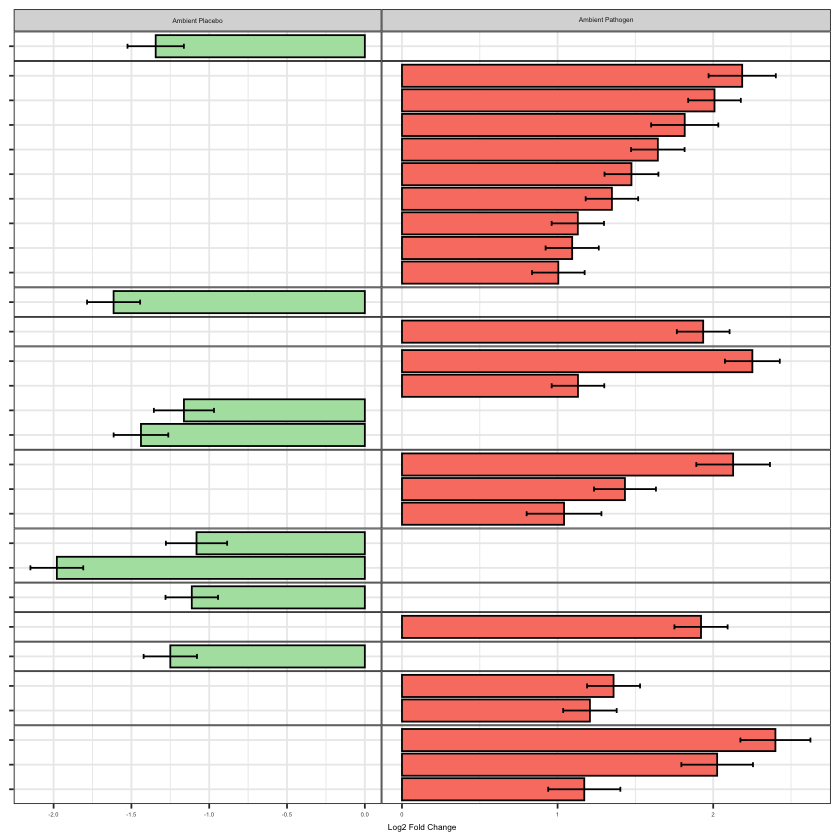

In [47]:
combo_labs <- as_labeller(c("Ambient Pathogen" = "Ambient~Pathogen",
                          "Ambient Placebo" = "Ambient~Placebo"), default = label_parsed)

F1 <- df_fig %>%
filter(lfc_ComboAmbient_Pathogen < -0.5 | lfc_ComboAmbient_Pathogen > 0.5)  %>%
#filter(ASVs!=ASV961
 filter(passed_ss_ComboAmbient_Pathogen == "TRUE") %>%
  mutate_if(is.character, str_replace_all, pattern = "o__", replacement = "") %>%
 
  mutate(
    direction = ifelse(lfc_ComboAmbient_Pathogen > 0, "Ambient Pathogen", "Ambient Placebo"),
    direction = factor(direction, levels = c("Ambient Placebo", "Ambient Pathogen"))
  ) %>%
  ggplot(aes(x = reorder(ASVs, lfc_ComboAmbient_Pathogen), y = lfc_ComboAmbient_Pathogen, fill = direction)) +
  geom_bar(stat = "identity", color = "black") +
  geom_errorbar(aes(ymin = lfc_ComboAmbient_Pathogen - se_ComboAmbient_Pathogen, 
                    ymax = lfc_ComboAmbient_Pathogen + se_ComboAmbient_Pathogen), width = 0.2) +
  coord_flip() +
  labs(
    x = "ASVs",
    y = "Log2 Fold Change",
    fill = "Direction"
  ) +
  scale_fill_manual(values = c("Ambient Pathogen" = "salmon", "Ambient Placebo" = "#AFE1AF")) +
  facet_grid(Order ~
             direction, 
             space = "free", scales = "free",
             switch = "y",
             labeller = labeller(direction = combo_labs)
            ) +
  theme_bw() +
  theme(
    axis.title.x = element_text(size = 5),
    axis.title.y = element_blank(),
    axis.text.x = element_text(size = 3.5),
    axis.text.y = element_blank(),
    strip.text.x = element_text(size = 4),
    strip.text.y = element_blank(),
    #  strip.text.y = element_text(size=5),
    legend.text = element_text(size = 5),
    legend.title = element_text(size = 5),
    legend.position = "none",
    panel.spacing.x = unit(0.0, "lines"),
    panel.spacing.y = unit(0.0, "lines")
  )
F1

In [20]:
psr_fill_melt = ps_disease  %>%  
  #tax_glom("Genus") %>% 
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()   


taxa_fil= df_fig %>% column_to_rownames("taxon")%>%
as.matrix


ps_DLPL=phyloseq(otu_table(ASVs, taxa_are_rows=TRUE), 
               sample_data(meta),
              tax_table(taxa_fil))
ps_DLPL=subset_samples(ps_DLPL, !ID %in% dups & Genotype!="U41")
ps_DLPL



ps_ancom_APa = subset_samples(ps_DLPL,
                      #Type=="Clipped" &  
                              Pairs=="paired" & Combo %in% select 
                             )

ps_ancom_APa 
#ps_ancom_APa = subset_samples(ps_ancom_APa, Pairs=="paired")
#ps_ancom_APa

psr_fill_melt = ps_ancom_APa  %>%  
  #tax_glom("Genus") %>% 
  transform_sample_counts(function(x) {x/sum(x)} ) %>% # Transform to rel. abundance
  psmelt()  


phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 45 taxa and 252 samples ]
sample_data() Sample Data:       [ 252 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 45 taxa by 22 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 45 taxa and 62 samples ]
sample_data() Sample Data:       [ 62 samples by 58 sample variables ]
tax_table()   Taxonomy Table:    [ 45 taxa by 22 taxonomic ranks ]

In [21]:
head(psr_fill_melt)

,OTU,Sample,Abundance,sample_names,featurecounts,Initial_sample_ID,Tag,start_date,event_date,Date_Collected,⋯,passed_ss_.Intercept.,passed_ss_ComboAmbient_Pathogen,Kingdom,Phylum,Class,Order,Family,Genus,Species,ASVs
,<chr>,<chr>,<dbl>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
478,35ded7bfcbb8e3a80e06696b551b0b97,N85-A055,1,N85-A055,31470,85,A055,2020-08-19,2020-11-03,3-Nov-20,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Vibrionales,f__Vibrionaceae,g__Vibrio,g__Vibrio Genus,ASV_2140
517,3790ac5be14bbbdc8719ce6632dcb64b,N182-A069,1,N182-A069,32430,182,A069,2020-08-19,2020-11-08,8-Nov-20,⋯,FALSE,TRUE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Vibrionales,f__Vibrionaceae,g__Vibrio,g__Vibrio Genus,ASV_2224
700,4ca08cf028bb6992f998bf37f206c01d,N141-A103,1,N141-A103,23261,141,A103,2020-08-19,2020-11-06,6-Nov-20,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Alteromonadales,f__Colwelliaceae,g__Thalassotalea,g__Thalassotalea Genus,ASV_3091
973,66760a62cc03e185f372c9797b2b48a9,N126-A154,1,N126-A154,32407,126,A154,2020-08-19,2020-11-06,6-Nov-20,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Endozoicomonadaceae,g__Endozoicomonas,s__Acropora_cervicornis,ASV_4109
989,66760a62cc03e185f372c9797b2b48a9,N104-276,1,N104-276,20691,104,276,2020-08-19,2020-11-05,5-Nov-20,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Endozoicomonadaceae,g__Endozoicomonas,s__Acropora_cervicornis,ASV_4109
1439,9c37ff0de653f2dba99bce320e9ffe32,N210-A189,1,N210-A189,22869,210,A189,2020-08-19,2020-11-10,10-Nov-20,⋯,FALSE,FALSE,d__Bacteria,p__Proteobacteria,c__Gammaproteobacteria,o__Oceanospirillales,f__Endozoicomonadaceae,g__Endozoicomonas,s__Acropora_cervicornis,ASV_6224


In [90]:
psr_fill_melt$lfc_ComboAmbient_Pathogen

[1] " 2.025417" " 1.171485" " 1.659158" "-1.302854" "-1.302854" "-1.155617"
   [7] "-1.448841" "-1.448841" "-1.445068" "-1.614496" "-1.081650" "-1.438588"
  [13] "-1.155617" "-1.112034" "-1.343973" "-1.712662" "-1.712662" "-1.712662"
  [19] "-1.712662" "-1.712662" "-1.712662" "-1.712662" "-1.712662" "-1.438588"
  [25] "-1.343973" "-1.302854" "-1.302854" "-3.483839" "-3.483839" "-1.155617"
  [31] "-1.192576" "-3.483839" "-3.483839" "-3.483839" "-3.483839" "-1.250036"
  [37] " 1.568978" "-3.483839" "-3.483839" " 1.310983" " 1.310983" "-1.979176"
  [43] " 2.186323" " 2.186323" "-1.448841" " 1.816912" " 1.816912" " 2.186323"
  [49] " 1.816912" "-1.155617" "-1.582481" "-1.343973" " 1.041453" " 1.171485"
  [55] "-1.302854" "-1.155617" " 2.025417" " 1.171485" " 1.041453" " 1.207784"
  [61] "-1.448841" " 2.128107" " 1.659158" " 1.041453" "-1.302854" "-1.445068"
  [67] "-1.155617" " 1.659158" " 2.399785" "-1.445068" " 1.474662" " 1.659158"
  [73] "-1.445068" " 1.226257" " 1.432878" "-1.155617" "-1.155617" "-1.155617"
  [79] "-1.302854" " 1.659158" " 1.041453" " 2.128107" " 2.399785" "-1.302854"
  [85] "-1.155617" " 2.025417" "-1.155617" "-1.155617" "-1.250036" " 1.171485"
  [91] " 2.128107" " 1.310983" "-1.155617" " 1.432878" "-1.445068" "-1.448841"
  [97] " 1.310983" " 2.025417" "-1.302854" " 1.432878" "-1.302854" "-1.302854"
 [103] " 2.005709" " 2.186323" "-1.302854" " 2.399785" " 2.128107" "-1.448841"
 [109] "-1.302854" "-1.448841" "-1.445068" "-1.302854" "-1.445068" "-1.448841"
 [115] " 1.226257" "-1.445068" "-1.445068" " 2.025417" "-1.302854" "-1.155617"
 [121] "-1.448841" " 1.171485" "-1.448841" "-1.448841" " 1.568978" " 1.816912"
 [127] " 1.171485" " 2.399785" " 1.432878" "-1.712662" "-1.445068" " 1.041453"
 [133] "-1.582481" "-1.582481" "-1.192576" " 1.310983" "-1.448841" "-1.448841"
 [139] " 1.279287" "-1.582481" "-1.155617" "-1.582481" "-1.582481" " 1.041453"
 [145] " 1.171485" "-1.192576" "-1.192576" "-1.192576" "-1.582481" " 1.207784"
 [151] "-1.582481" "-3.483839" "-1.192576" " 1.432878" "-1.445068" " 2.251651"
 [157] " 2.025417" "-1.192576" " 2.186323" " 1.279287" " 2.128107" " 2.025417"
 [163] "-1.192576" " 2.025417" " 2.128107" " 2.008364" "-1.155617" " 1.432878"
 [169] " 2.399785" " 1.432878" " 2.128107" "-1.302854" " 1.359773" " 1.041453"
 [175] "-1.192576" " 2.399785" " 1.432878" "-1.155617" " 1.359773" " 1.041453"
 [181] "-1.448841" " 1.073540" " 2.186323" " 1.171485" " 1.004652" " 1.310983"
 [187] " 2.186323" "-1.445068" " 1.568978" " 2.251651" " 1.310983" " 1.816912"
 [193] "-1.445068" " 1.568978" " 1.226257" " 2.128107" " 1.816912" " 2.128107"
 [199] " 2.128107" " 2.128107" " 2.005709" " 1.310983" " 1.130041" " 2.008364"
 [205] " 1.659158" "-1.582481" " 1.279287" "-1.162520" " 1.432878" "-1.192576"
 [211] " 2.005709" " 1.644259" " 1.093864" " 1.041453" " 1.568978" " 1.041453"
 [217] " 1.568978" " 1.093864" " 1.041453" " 1.171485" " 1.310983" " 1.816912"
 [223] " 1.279287" " 2.128107" " 1.041453" " 1.207784" " 2.251651" " 1.073540"
 [229] " 1.935686" " 2.025417" "-1.438588" "-1.112034" " 1.131001" " 2.008364"
 [235] " 1.207784" " 1.226257" " 1.659158" " 1.349117" " 2.005709" " 1.659158"
 [241] " 1.171485" " 2.399785" "-1.155617" " 1.432878" " 2.399785" "-1.302854"
 [247] " 1.359773" " 1.816912" " 1.226257" " 1.279287" " 2.186323" " 1.568978"
 [253] " 1.568978" " 1.568978" "-1.445068" " 1.131001" " 2.128107" " 2.186323"
 [259] " 2.186323" " 1.207784" " 1.568978" "-1.112034" "-1.448841" " 2.695652"
 [265] " 1.226257" " 2.128107" "-1.162520" " 2.025417" " 1.432878" "-1.582481"
 [271] "-1.192576" " 1.359773" "-1.614496" " 1.816912" " 1.359773" " 1.921686"
 [277] " 1.131001" "-1.712662" " 2.186323" "-1.250036" " 1.816912" " 2.399785"
 [283] "-1.302854" " 1.073540" " 1.226257" " 2.025417" " 2.186323" " 1.171485"
 [289] " 1.226257" "-1.445068" "-1.448841" " 1.073540" " 2.186323" "-1.155617"
 [295] " 1.171485" " 1.474662" "-1.979176" " 1.171485" " 1.432878" " 1.474662"
 [301] "-1.343973" " 1.226257" " 1.171485" " 2.128107

In [89]:
psr_fill_melt %>%ifelse(lfc_ComboAmbient_Pathogen > 0, "NH4", "Ambient")

ERROR: Error in ifelse(., lfc_ComboAmbient_Pathogen > 0, "NH4", "Ambient"): unused argument ("Ambient")



Ambient~Disease Ambient~Placebo 
             40             173 


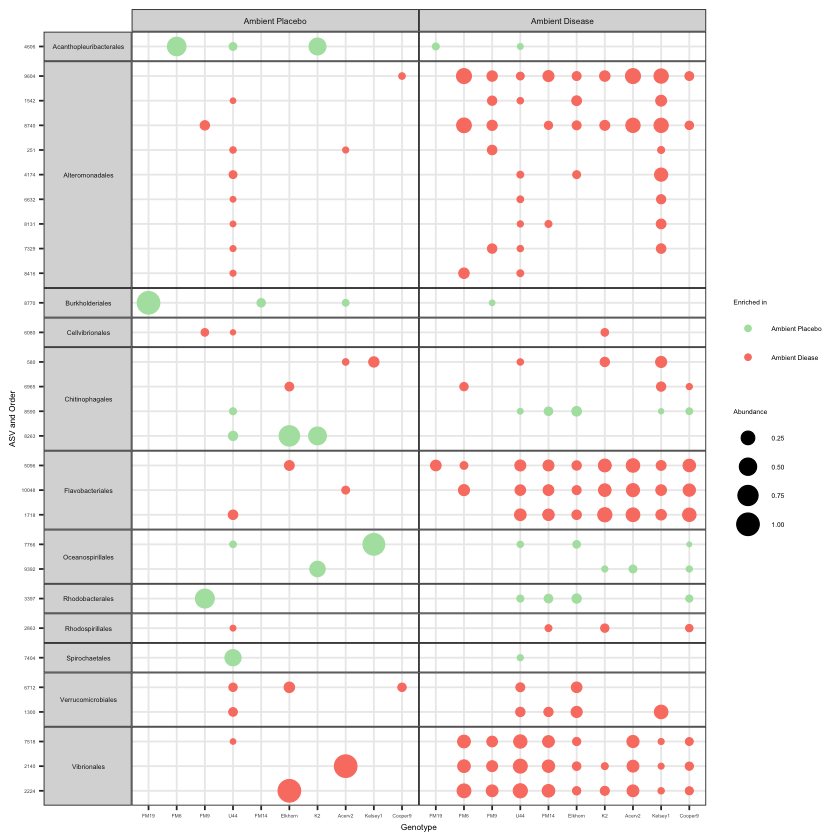

In [92]:
library(stringr)
psr_fill_melt <- psr_fill_melt %>%
  mutate(Combo = factor(Combo, levels = c("Ambient_Placebo", "Ambient_Pathogen", "NH4_Placebo", "NH4_Pathogen")))
# Define labellers
combo_labs <- as_labeller(c(
  "Ambient_Placebo" = "Ambient~Placebo",
  "Ambient_Pathogen" = "Ambient~Disease",
  "NH4_Placebo" = "NH[4]~Placebo",
  "NH4_Pathogen" = "NH[4]+Disease"
), default = label_parsed)


lab1 <- c(expression(Ambient~Placebo),
          
          expression(Ambient~Diease))
# Plot
F2 <- psr_fill_melt %>%
  as.data.frame() %>%
  mutate(
    Abundance = as.numeric(as.character(Abundance)),
    lfc_ComboAmbient_Pathogen = as.numeric(str_trim(as.character(lfc_ComboAmbient_Pathogen)))
  ) %>%
  filter(
    passed_ss_ComboAmbient_Pathogen == "TRUE",
    Abundance > 0,
    !is.na(Severity)
  ) %>%
  mutate(
   Enriched  = ifelse(lfc_ComboAmbient_Pathogen > 0, "Ambient~Placebo", "Ambient~Disease")
  ) %>%
  { print(table(.$Enriched)); . } %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "o__", ""))) %>%
  mutate(across(where(is.character), ~ str_replace_all(.x, "ASV_", ""))) %>%

  ggplot(aes(x = Genotype, y = reorder(ASVs, lfc_ComboAmbient_Pathogen))) +
  geom_point(aes(size = Abundance, color = Enriched)) +
  scale_color_manual("Enriched in", values = c("#AFE1AF", "salmon"),labels=lab1) +
  facet_grid(
    Order ~ Combo,
    space = "free",
    scales = "free",
    switch = "y",
      labeller = labeller(Combo = combo_labs
    )
  ) +
  theme_bw() +
  theme(
    axis.title.x = element_text(size = 5),
    axis.title.y = element_text(size = 5),
    axis.text.x = element_text(size = 3),
    axis.text.y = element_text(size = 3),
    strip.text.y = element_text(size = 4),
    strip.text.y.left = element_text(angle = 0),
    strip.text.x = element_text(size = 5),
    legend.text = element_text(size = 4),
    legend.title = element_text(size = 4),
    panel.spacing.x = unit(0.0, "lines"),
    panel.spacing.y = unit(0.0, "lines")
  ) +
#theme(axis.text.x = element_text(angle = 20, hjust = 1)) +
#guides(fill = guide_legend(keywidth = 0.30, , keyheight =.60, ncol=1)) +
  ylab("ASV and Order")
F2

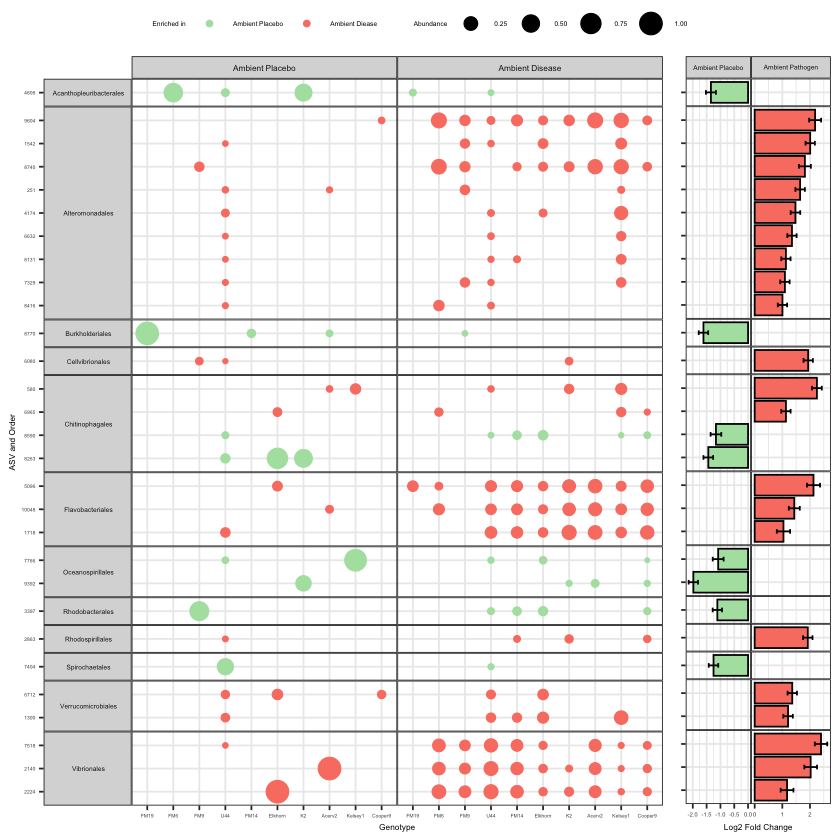

In [93]:
 ggpubr::ggarrange(F2, F1, common.legend = TRUE, legend = "top",
                   widths=c(2,0.5))
ggsave("/Users/stephanie.rosales/Documents/omics_projects/Resitada/figures/new_ANCOM_pathogen.jpg", 
      width = 6, height = 4, units = "in", dpi=300)

In [94]:
F2_data <- psr_fill_melt %>%
  as.data.frame() %>%
  filter(
    passed_ss_ComboAmbient_Pathogen == "TRUE",
    !is.na(Severity)
  )

print(unique(F2_data$Combo))

[1] Ambient_Placebo  Ambient_Pathogen
Levels: Ambient_Placebo Ambient_Pathogen NH4_Placebo NH4_Pathogen
